ReadMe:

1. Reproduce the Sample code for understamding of Perceiver Implementation SOTA technology for image classification

      Perceiver use data augmentation, Feedforward network, patch creation and encoding of patch layer. To build the Perceiver model you need to implement Cross-attention, Transformer module.

2. Run the code using the CIFAR-100 dataset with GPU runtime, 10 epochs. 

      Results : 1 epoch took 4Hrs and didnt complete the one epoch run.

      Epoch 1/10
        404/704 [================>.............] - ETA: 4:44:34 4Hrs - loss: 4.4256 - acc: 0.0418 - top5-acc: 0.1474

3. Use Weights and Biases to run the code with GPU runtime, 10 epochs.

      Hyperparameters use first run : 

      Image size: 64 X 64 = 4096

      Patch size: 2 X 2 = 4 

      Patches per image: 1024

      Elements per patch (3 channels): 12

      Latent array shape: 256 X 256

      Data array shape: 1024 X 256

    Results : The hyperparameters needed to be optimize to use the GPU compute because of huge allocation of tensor with shape[64,256,8,256]. 

        ResourceExhaustedError:  OOM when allocating tensor with shape[64,256,8,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	    [[node perceiver/model_1/multi_head_attention_3/einsum_3/Einsum (defined at <ipython-input-15-05efc0397541>:89) ]]
        Hint: If you want to see a list of allocated tensors 4Hrs when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
        [Op:__inference_train_function_25330]

        Function call stack:
        train_function
4. Change the hyperparameters to a lower dimension 

      Image size: 32 X 32 = 1024

      Patch size: 4 X 4 = 16 
      
      Patches per image: 64
      
      Elements per patch (3 channels): 48
      
      Latent array shape: 64 X 64
      
      Data array shape: 64 X 64

      Results : 
      The model achieved Test accuracy: 55.79%

      Test top 5 accuracy: 95.1% running only for 10 epochs.

Conclusion : Smaller data array parameters gives higher accuracy compared with bigger data array parameters. 

Reference : 

https://keras.io/examples/vision/perceiver_image_classification/

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/perceiver_image_classification.ipynb

https://github.com/wandb/client/archive/feature/code-save.zip





In [34]:
!pip install -U tensorflow-addons

In [35]:
#importing the libraries
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import PIL
import PIL.Image

# Imports module
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from imutils import paths
import os
%matplotlib inline

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Wandb

In [36]:
!nvidia-smi

Sat Oct  9 22:45:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |   1196MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     - 10.4 MB 550 kB/s
     |████████████████████████████████| 180 kB 4.1 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 139 kB 21.7 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 70 kB 7.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=40bc1b9f3a0d0d3f1d151d66e684129b23d3acb97735e49d126735aa5466b9ed
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=3f478df340877313b11214234631ad06da4caca992fef734e3b62462fbd78dfc
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=620e217d6057a9ea1f4f0cba24189

In [37]:
!pip install wandb --upgrade

In [38]:
# Other imports
import wandb
wandb.login()
from wandb.keras import WandbCallback
from tqdm import tqdm

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Prepare Dataset

In [56]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")

print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [54]:
# Use CIFAR-10 not CIFAR-100
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

First hyperparameter tuning


In [40]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 50
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 2  # Size of the patches to be extract from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
latent_dim = 256  # Size of the latent array.
projection_dim = 256  # Embedding size of each element in the data and latent arrays.
num_heads = 8  # Number of Transformer heads.
ffn_units = [
    projection_dim,
    projection_dim,
]  # Size of the Transformer Feedforward network.
num_transformer_blocks = 4
num_iterations = 2  # Repetitions of the cross-attention and Transformer modules.
classifier_units = [
    projection_dim,
    num_classes,
]  # Size of the Feedforward network of the final classifier.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")
print(f"Latent array shape: {latent_dim} X {projection_dim}")
print(f"Data array shape: {num_patches} X {projection_dim}")

Image size: 64 X 64 = 4096
Patch size: 2 X 2 = 4 
Patches per image: 1024
Elements per patch (3 channels): 12
Latent array shape: 256 X 256
Data array shape: 1024 X 256


Second hyperparameter tuning

In [57]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
# num_epochs = 50
num_epochs = 10
dropout_rate = 0.2
# image_size = 64  # We'll resize input images to this size.
image_size = 32  # We'll resize input images to this size.
# patch_size = 2  # Size of the patches to be extract from the input images.
patch_size = 4  # Size of the patches to be extract from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
# latent_dim = 256  # Size of the latent array.
latent_dim = 64  # Size of the latent array.
# projection_dim = 256  # Embedding size of each element in the data and latent arrays.
projection_dim = 64  # Embedding size of each element in the data and latent arrays.
# num_heads = 8  # Number of Transformer heads.
num_heads = 2  # Number of Transformer heads.
ffn_units = [
    projection_dim,
    projection_dim,
]  # Size of the Transformer Feedforward network.
num_transformer_blocks = 4
num_iterations = 2  # Repetitions of the cross-attention and Transformer modules.
classifier_units = [
    projection_dim,
    num_classes,
]  # Size of the Feedforward network of the final classifier.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")
print(f"Latent array shape: {latent_dim} X {projection_dim}")
print(f"Data array shape: {num_patches} X {projection_dim}")

Image size: 32 X 32 = 1024
Patch size: 4 X 4 = 16 
Patches per image: 64
Elements per patch (3 channels): 48
Latent array shape: 64 X 64
Data array shape: 64 X 64


Note that, in order to use each pixel as an individual input in the data array,
set `patch_size` to 1.

## Use data augmentation

In [58]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement Feedforward network (FFN)

In [59]:

def create_ffn(hidden_units, dropout_rate):
    ffn_layers = []
    for units in hidden_units[:-1]:
        ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    ffn_layers.append(layers.Dense(units=hidden_units[-1]))
    ffn_layers.append(layers.Dropout(dropout_rate))

    ffn = keras.Sequential(ffn_layers)
    return ffn


## Implement patch creation as a layer

In [60]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into
a vector of size `latent_dim`. In addition, it adds a learnable position embedding
to the projected vector.

Note that the orginal Perceiver paper uses the Fourier feature positional encodings.

In [61]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


## Build the Perceiver model

The Perceiver consists of two modules: a cross-attention
module and a standard Transformer with self-attention.

### Cross-attention module

The cross-attention expects a `(latent_dim, projection_dim)` latent array,
and the `(data_dim,  projection_dim)` data array as inputs,
to produce a `(latent_dim, projection_dim)` latent array as an output.
To apply cross-attention, the `query` vectors are generated from the latent array,
while the `key` and `value` vectors are generated from the encoded image.

Note that the data array in this example is the image,
where the `data_dim` is set to the `num_patches`.

In [62]:

def create_cross_attention_module(
    latent_dim, data_dim, projection_dim, ffn_units, dropout_rate
):

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, projection_dim)),
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = layers.Attention(use_scale=True, dropout=0.1)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attention_output = layers.Add()([attention_output, latent_array])

    # Apply layer norm.
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    # Apply Feedforward network.
    ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
    outputs = ffn(attention_output)
    # Skip connection 2.
    outputs = layers.Add()([outputs, attention_output])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


### Transformer module

The Transformer expects the output latent vector from the cross-attention module
as an input, applies multi-head self-attention to its `latent_dim` elements,
followed by feedforward network, to produce another `(latent_dim, projection_dim)` latent array.

In [63]:

def create_transformer_module(
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
        x3 = ffn(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=x0)
    return model


### Perceiver model

The Perceiver model repeats the cross-attention and Transformer modules
`num_iterations` times—with shared weights and skip connections—to allow
the latent array to iteratively extract information from the input image as it is needed.

In [64]:

class Perceiver(keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.
        self.patcher = Patches(self.patch_size)

        # Create patch encoder.
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super(Perceiver, self).build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patcher(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits


## Compile, train, and evaluate the mode

In [65]:

def run_experiment(model):

    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.LAMB(
        learning_rate=learning_rate, weight_decay_rate=weight_decay,
    )

    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=3
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )

    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


First run using GPU Colab 
It took 4hrs for one epoch and the colab crashed.

In [ ]:
perceiver_classifier = Perceiver(
    patch_size,
    num_patches,
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
    num_iterations,
    classifier_units,
)


history = run_experiment(perceiver_classifier)

Epoch 1/10
404/704 [================>.............] - ETA: 4:44:34 - loss: 4.4256 - acc: 0.0418 - top5-acc: 0.1474

Use Wandb (Weight and Bias) GPU runtime and 50(first run) and 10(second run) epochs experiment.

In [66]:
## Run this for Wandb
perceiver_classifier = Perceiver(
    patch_size,
    num_patches,
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
    num_iterations,
    classifier_units,
)

In [67]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["acc"], label="test_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

Note that training the perceiver model with the current settings on a V100 GPUs takes
around 200 seconds.

In [17]:
## DO NOT RUN
# perceiver_classifier = Perceiver(
#     patch_size,
#     num_patches,
#     latent_dim,
#     projection_dim,
#     num_heads,
#     num_transformer_blocks,
#     ffn_units,
#     dropout_rate,
#     num_iterations,
#     classifier_units,
# )


# history = run_experiment(perceiver_classifier)

In [52]:
# First run
# Train the supervised model with full data
wandb.init(project="perceiver0", id="self-supervised-learning-training0")

model = run_experiment(perceiver_classifier)

plot_training(model)

Epoch 1/50


ResourceExhaustedError: ignored

Epoch 1/10
704/704 [==============================] - 103s 110ms/step - loss: 2.5802 - acc: 0.2483 - top5-acc: 0.6976 - val_loss: 1.8219 - val_acc: 0.3248 - val_top5-acc: 0.8384
Epoch 2/10
704/704 [==============================] - 75s 107ms/step - loss: 2.2817 - acc: 0.3330 - top5-acc: 0.7816 - val_loss: 1.6329 - val_acc: 0.3978 - val_top5-acc: 0.8928
Epoch 3/10
704/704 [==============================] - 75s 107ms/step - loss: 2.1877 - acc: 0.3674 - top5-acc: 0.8091 - val_loss: 1.5614 - val_acc: 0.4266 - val_top5-acc: 0.9030
Epoch 4/10
704/704 [==============================] - 75s 107ms/step - loss: 2.1058 - acc: 0.3935 - top5-acc: 0.8331 - val_loss: 1.4439 - val_acc: 0.4694 - val_top5-acc: 0.9272
Epoch 5/10
704/704 [==============================] - 75s 107ms/step - loss: 2.0428 - acc: 0.4184 - top5-acc: 0.8507 - val_loss: 1.4021 - val_acc: 0.4898 - val_top5-acc: 0.9318
Epoch 6/10
704/704 [==============================] - 75s 107ms/step - loss: 1.9881 - acc: 0.4363 - top5-acc: 0.86

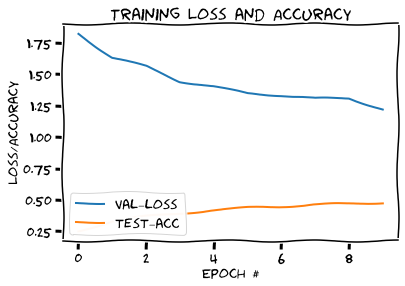

In [68]:
# Second run
# Train the supervised model with full data
wandb.init(project="perceiver06", id="self-supervised-learning-training06")

model = run_experiment(perceiver_classifier)

plot_training(model)

After 10 epochs, the Perceiver model achieves around 55% accuracy and 95% top-5 accuracy on the test data.

As mentioned in the ablations of the [Perceiver](https://arxiv.org/abs/2103.03206) paper,
you can obtain better results by increasing the latent array size,
increasing the (projection) dimensions of the latent array and data array elements, however my evaluations shows lower dimension projection shows better accuracy.

I decrease the latent array, data array shape but increase the elements per patch improve the image accuracy. 

Using high dimensional array requires a higher compute and the GPU can't process it.

Before :

Image size: 64 X 64 = 4096

Patch size: 2 X 2 = 4 

Patches per image: 1024

Elements per patch (3 channels): 12

Latent array shape: 256 X 256

Data array shape: 1024 X 256

After :

Image size: 32 X 32 = 1024

Patch size: 4 X 4 = 16 

Patches per image: 64

Elements per patch (3 channels): 48

Latent array shape: 64 X 64

Data array shape: 64 X 64
